# Importing Libraries

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv

# Download Data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-09-22 10:15:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-09-22 10:15:06 (129 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



# Create Time & Series from Data

In [13]:
time_steps = []
sunspots = []

with open('/tmp/sunspots.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)

  for row in reader:
    sunspots.append(float(row[2]))
    time_steps.append(int(row[0]))

print(time_steps[:10])
print(sunspots[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[96.7, 104.3, 116.7, 92.8, 141.7, 139.2, 158.0, 110.5, 126.5, 125.8]


In [14]:
time = np.array(time_steps)
series = np.array(sunspots)

print(time[:10])
print(series[:10])

[0 1 2 3 4 5 6 7 8 9]
[ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8]


In [15]:
def plot_time_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

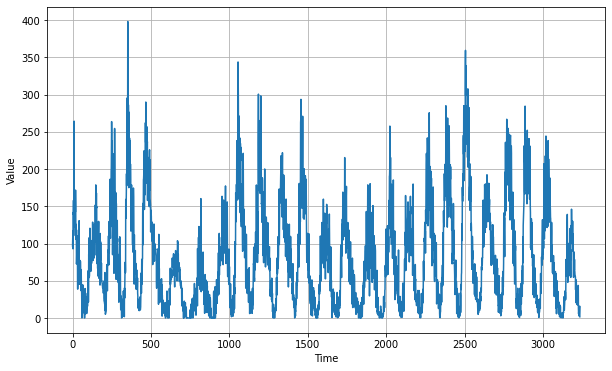

In [16]:
plt.figure(figsize=(10, 6))
plot_time_series(time, series)

# Split Data

In [17]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Windowed Data

In [18]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [20]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
for x, y in dataset:
  print(x)
  print(y)
  break

tf.Tensor(
[[148.7 147.2 150.  ...   7.   17.   18.7]
 [ 19.5   7.8  17.5 ...  18.7  30.5  14. ]
 [  0.3   0.7   0.  ...   9.7  24.8  30.8]
 ...
 [ 80.5  73.3  78.  ...  77.2 101.5 102.3]
 [  8.5  24.    7.  ...  55.8  54.3  66.3]
 [ 23.3  21.7  20.  ... 210.5 174.  172.7]], shape=(32, 60), dtype=float64)
tf.Tensor(
[ 11.3  25.5   3.8  34.3  47.3  88.3   9.5 159.5  58.  223.3  53.7  88.
  57.5  41.7 183.3   0.  173.3 194.6  80.  142.3  29.2 111.3   0.   34.5
   0.   11.5 122.7  98.  211.1  99.5  80.3 220.3], shape=(32,), dtype=float64)


# Create & Train the Model

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss="mse", 
    optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
)

model.summary()

history = model.fit(dataset,epochs=100,verbose=0)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1220      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


# Forecasting

In [23]:
print(len(series))
print(window_size)

3235
60


In [24]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

print(results[:10])

[127.72319  112.450836 110.63345  117.671906 116.75455  138.59673
 163.17145  176.03699  149.05574  129.47357 ]


In [25]:
print(len(x_valid))
print(len(results))

235
235


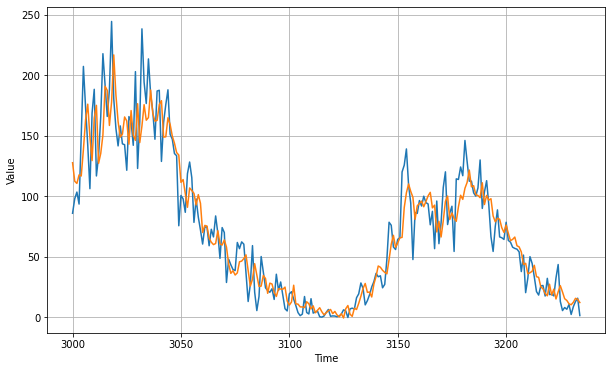

In [28]:
plt.figure(figsize=(10, 6))

plot_time_series(time_valid, x_valid)
plot_time_series(time_valid, results)

# Loss

In [29]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.505211